### Algorithm for constructing quadtrees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor

In [2]:
# Morton order achieved by interleaving bits
# x = 3, bin(x) = '0b11' ==> '0b00011' to match length of y
# y = 22, bin(y) = '0b10110'
# 
# Interleaving with x binary in even positions, and y in odd, gives
# 
# (morton number) m = '0b1000101101'

def to_morton(x,y):
    """
    Converts 2-D indicies (x,y) into corresponding morton index (m)
    """
    
    bx = bin(x)[2:] # ignore '0b' before binary encoding
    by = bin(y)[2:]
    
    lx = len(bx)
    ly = len(by)
    
    lm = 2*max(lx,ly) # Get length must be multiple of 2 twice the length of larger of x or y
    
    m = ['0']*(lm)
    
    for i in range(lx):
        m[lm - 1 - 2*i] = bx[lx - 1 - i]
    
    for i in range(ly):
        m[lm - 2 - 2*i] = by[ly - 1 - i]
        
    m = ['0b'] + m
    m = ''.join(m)
    m = int(m,2)

    return(m)


def from_morton(m):  
    """
    Converts morton index (m) into corresponding 2-D index (x,y)
    """
    
    bm = bin(m)[2:]
    
    lbm = len(bm) # length of binary
    lm,r = divmod(lbm,2) # get length to nearest power of 2
    lm = (lm + r)*2
    
    lx = int(lm/2) # Length of x and y arrays
    
    m = ['0']*lm
    
    x = ['0']*lx
    y = ['0']*lx
    
    for i in range(lbm):
        m[lm - 1 - i] = bm[lbm - 1 - i]
    
    for i in range(lx):
        x[i] = m[2*i + 1]
        y[i] = m[2*i]
        
    x = ['0b'] + x
    y = ['0b'] + y
    x = ''.join(x)
    y = ''.join(y)
    x = int(x,2)
    y = int(y,2)
        
    return(x,y)

def morton_table(depth):
    """
    Generates 2-D morton lookup table of dimensions 2**depth x 2**depth
    """
    
    x = np.arange(2**depth)
    y = np.arange(2**depth)
    
    m_table = np.zeros((2**depth,2**depth),dtype = 'int32')
    
    for i in range(2**depth):
        for j in range(2**depth):
            m_table[i,j] = to_morton(x[i],y[j])
            
    return(m_table)

def m_above(m,d1,d2): 
    """
    m = morton index at current depth
    d1 = current depth
    d2 = depth shallower than d1
    
    Returns morton index that original index in level d1 would have in level d2
    """
    
    m_d2 = floor(m / 4**(d1 - d2))
    
    return(m_d2)

def m_below(m,d1,d2):
    """
    m = morton index at current depth
    d1 = current depth
    d2 = depth deeper than d1
    
    Returns range of morton indicies in level d2 that fall under index in d1
    """ 
    
    n = d2 - d1
    
    m_d2_min = int(m*4**n)
    m_d2_max = int((m + 1)*4**n - 1)
    return(m_d2_min,m_d2_max)

In [3]:
# Generate initial configuration of psi
depth = 4

# Number of grid points
M = 2**depth
N = 2**depth

# Lattice spacing 

Lx = 10.0
Ly = 10.0
dx = Lx/M
dy = Ly/N

# Width of interface
zeta = Lx/20

x = np.linspace(0,Lx,N+1)
y = np.linspace(0,Ly,M+1)

xx,yy = np.meshgrid(x,y)

rr = (xx**2 + yy**2)**0.5

phi = rr - (2*Lx*Ly/np.pi)**0.5

psi = 0.5*(1 + np.tanh(phi/zeta))

In [4]:
def gradient_2D(f,dx,dy):
    
    dfdx = np.zeros(np.shape(f))
    dfdy = np.zeros(np.shape(f))
    
    dfdx[:,1:-1] = (f[:,2:] - f[:,0:-2])/(2*dx)
    dfdx[:,0] = 0.0
    dfdx[:,-1] = 0.0
    
    dfdy[1:-1,:] = (f[2:,:] - f[0:-2,:])/(2*dy)
    dfdy[0,:] = 0.0
    dfdy[-1,:] = 0.0

    return(dfdx,dfdy)

In [5]:
dpsi_dx, dpsi_dy = gradient_2D(psi,dx,dy)

mag_grad_psi = (dpsi_dy**2 + dpsi_dx**2)**0.5 # Magnitude of gradient vector

height = 6
width = (Lx/Ly)*height

# Unit cells should be centered
domain = (mag_grad_psi[1:,0:-1] + mag_grad_psi[0:-1,0:-1] + mag_grad_psi[1:,1:] + mag_grad_psi[0:-1,1:])/4

In [6]:
def combine_criteria(area,val):
    if val*area > 0.005:
        combine = 0 # do not combine
    else:
        combine = 1 # combine 
    return(combine)

In [7]:
# Create morton-ordered voxel grid

m_val = np.zeros(2**depth * 2**depth)
m_x = np.zeros(2**depth * 2**depth)
m_y = np.zeros(2**depth * 2**depth)

for i in range(2**depth):
    for j in range(2**depth):
        m_index = to_morton(i,j)
        m_val[m_index] = domain[i,j]
        m_x[m_index] = i*dx + 0.5*dx
        m_y[m_index] = j*dy + 0.5*dx

In [8]:
# Create Classes 

class leaf:
    def __init__(self,x,y,val,depth,morton):
        
        self.x = x           # X value of center of leaf domain
        self.y = y           # Y value of center of leaf domain
        self.val = val       # Value across leaf domain
        self.depth = depth   # Depth in tree
        self.height = 0      # Height of subtree (0 because leaf)
        self.morton = morton # Morton index at depth
        
        self.isleaf = 1
        self.isnode = 0
        self.index = 0       # Index in final leaf-list

class node:
    def __init__(self,kids,depth,morton):
        
        self.children = [None]*4
        self.height = kids[0].height
        
        for i in range(0,4):
            self.children[i] = kids[i]
            if kids[i].height > self.height:
                self.height = kids[i].height
                
        self.height = self.height + 1 # Height of subtree
            
        self.depth = depth   # Depth from root of tree
        self.morton = morton # Morton index at depth
        
        self.isleaf = 0
        self.isnode = 1
        
    def find_leaf(self,l_morton,l_depth): # Attempt to retrieve leaf given morton index and depth
        mynode = self
        found = 0
        
        while mynode.height + mynode.depth >= l_depth and mynode.isnode == 1:
            ind = m_above(l_morton,l_depth, mynode.depth + 1)
            ind = ind % 4
            mynode = mynode.children[ind]
            
        if mynode.isleaf == 1:
            found = 1
            
        return(found)
    
    def list_leaves(self):
        
        leaves_morton = []
        leaves_depth = []
        
        s = []
        
        s.append(self)
        
        while len(s) > 0:
            
            mynode = s.pop(0) # Pop from beginning of list
            
            for i in range(4):
                if mynode.children[i].isleaf == 1:
                    leaves_morton = leaves_morton + [mynode.children[i].morton]
                    leaves_depth = leaves_depth + [mynode.children[i].depth]
                else:
                    s.append(mynode.children[i])
        
        return(leaves_morton,leaves_depth)
    
    def index_leaf(self,l_morton,l_depth,l_index):
            
        ind = m_above(l_morton,l_depth, self.depth + 1)
        ind = ind % 4
            
        if self.children[ind].isnode == 1:
            
            self.children[ind].index_leaf(l_morton,l_depth,l_index)
            
        else:
            self.children[ind].index = l_index

In [9]:
# Initialize input (initially all leaves)

current_input = []
q = [None,None,None,None]

for i in range((2**depth)**2):
    myleaf = leaf(m_x[i],m_y[i],m_val[i],depth,i)
    current_input.append(myleaf)

In [10]:
# Build quadtree
d = depth - 1
queue = []

while d >= 0:
    
    for i in range((2**d)**2): # For length of input / 4
        
        all_leaf = 1
        
        for j in range(4): # Read in next group of 4 objects 
            q[j] = current_input[4*i + j]
            if q[j].isleaf == 0:
                all_leaf = 0
                
        next_morton = i # Get morton index of node/leaf being pushed into queue
        
        if all_leaf == 1: # If all 4 objects are leaves, can try to combine
            
            val_avg = (q[0].val + q[1].val + q[2].val + q[3].val)/4
            area = (Lx/2**d)**2
            
            if combine_criteria(area,val_avg) == 1: # Check if combining criteria are met
        
                balanced = 1
                neigh_depth = d + 2 # Can't have neighboring leaves more than 1 level apart
                neighbors = []
                
                # Range of morton indices of points 2 levels below "buried" by combined region
                m1, m2 = m_below(next_morton,d,neigh_depth) 
                x1,y1 = from_morton(m1)
                x2,y2 = from_morton(m2)
                x_min = min(x1,x2) # Extent of combined region on "buried" 2D grid 
                y_min = min(y1,y2)
                x_max = max(x1,x2)
                y_max = max(y1,y2)
                
                # Build list of potential illegal neighbors' morton indicies
                if x_min > 0:
                    for k in range(y_min,y_max + 1):
                        neighbors.append(to_morton(x_min - 1,k))
                    if y_min > 0:
                        neighbors.append(to_morton(x_min - 1,y_min - 1))
                    if y_max < 2**neigh_depth - 2:
                        neighbors.append(to_morton(x_min - 1,y_max + 1))
                        
                if x_max < 2**neigh_depth - 2:
                    for k in range(y_min,y_max + 1):
                        neighbors.append(to_morton(x_max + 1,k))
                    if y_min > 0:
                        neighbors.append(to_morton(x_max + 1,y_min - 1))
                    if y_max < 2**neigh_depth - 2:
                        neighbors.append(to_morton(x_max + 1,y_max + 1))
                    
                    
                if y_min > 0:
                    for k in range(x_min,x_max + 1):
                        neighbors.append(to_morton(k,y_min - 1))
                        
                if y_max < 2**neigh_depth - 2:
                    for k in range(x_min,x_max + 1):
                        neighbors.append(to_morton(k,y_max + 1))
                        
                # Check if illegal neighbors are present
                for n_morton in neighbors:
                    
                    isthere = 0
                    search_start = floor(n_morton / 4) # Index in input to start searching
                    
                    if current_input[search_start].isnode == 1:
                        isthere = current_input[search_start].find_leaf(n_morton,neigh_depth)
                    
                    if isthere == 1: # If it would create illegal neighbors, reject attempted combination
                        balanced = 0
                        break
                        
                if balanced == 1: # If mesh will stay balanced, combine leaves
                    x_avg = (q[0].x + q[1].x + q[2].x + q[3].x)/4
                    y_avg = (q[0].y + q[1].y + q[2].y + q[3].y)/4
                    next_push = leaf(x_avg,y_avg,val_avg,d,next_morton)

                else: # If mesh won't be balanced, make node instead
                    next_push = node(q,d,next_morton)

            else: # If combining critieria not met, then make node
                next_push = node(q,d,next_morton)
                
        else: # If not all 4 objects are leaves, then make node
            next_push = node(q,d,next_morton)
        
        # Push to next level
        queue.append(next_push) 

        
    current_input = queue
    queue = []
    d = d - 1
    
quadtree = current_input[0]

Bae, NOOO!
Bae, NOOO!
Bae, NOOO!


In [11]:
class v_node:
    
    def __init__(self,n_morton,n_depth):
        self.morton = n_morton
        self.depth = n_depth
        
        self.children = [None] * 4
        
    def insert_vertex(self,vert):
        
        m_next = m_above(vert.morton, vert.depth, self.depth + 1)
        ind = m_next % 4
        
        if self.depth == vert.depth - 1:
            
            if self.children[ind] == None:
                self.children[ind] = vert
                return(1,None) # Successfully inserted
            else:
                if self.children[ind].min_depth < vert.min_depth:
                    self.children[ind].min_depth == vert.min_depth
                    return(2,self.children[ind].index) # Vertex is already there but, updated maxleaf
                else:
                    return(0,None) # Vertex is already there, didn't update maxleaf
            
        else:
            if self.children[ind] == None:
                self.children[ind] = v_node(self.morton*4 + ind, self.depth + 1)
                
            return(self.children[ind].insert_vertex(vert))
        
    def find_vertex(self,v_morton,v_depth):
        m_next = m_above(v_morton, v_depth, self.depth + 1)
        ind = m_next % 4
        
        if self.depth == v_depth - 1:
            if self.children[ind] == None: # Node doesn't exist
                return(0,None)
            else:
                return(1,self.children[ind].index)
        else:
            if self.children[ind] == None:
                return(0,None)
            else:
                return(self.children[ind].find_vertex(v_morton,v_depth))
    
class vertex:
    def __init__(self,v_morton,v_depth,leaf_depth,index):
        self.morton = v_morton
        self.depth = v_depth
        self.index = index # Index in vertex list
        self.min_depth = leaf_depth # max depth of leaf it is vertex of 

In [12]:
# Move from centered based unit cells, to connected network of verticies

leaves_morton, leaves_depth = quadtree.list_leaves()
numleaves = len(leaves_morton)

vertex_depth = depth + 1
numvert = 0
vertex_list = []
vertex_tree = v_node(0,0) # Will store vertices in tree (makes searching for duplicates fast)

for i in range(numleaves):
    m_min, m_max = m_below(leaves_morton[i],leaves_depth[i],vertex_depth-1)
    x_min,y_min = from_morton(m_min)
    x_max,y_max = from_morton(m_max)
    
    # Get 4 verticies of each leaf
    v1 = to_morton(x_min,y_min)
    v2 = to_morton(x_min,y_max + 1)
    v3 = to_morton(x_max + 1,y_min)
    v4 = to_morton(x_max + 1,y_max + 1)
    
    current_vert = [v1,v2,v3,v4]
    
    for j in range(4):
        myvert = vertex(current_vert[j],vertex_depth,leaves_depth[i],numvert)
        new_vertex, change_ind = vertex_tree.insert_vertex(myvert)
        if new_vertex == 1:
            vertex_list.append(myvert)
            numvert = numvert + 1
        elif new_vertex == 2:
            vertex_list[change_ind].min_depth = myvert.min_depth

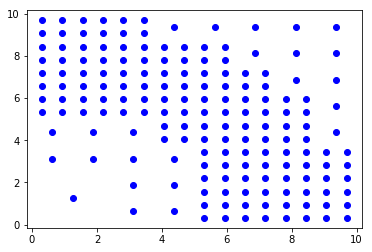

In [13]:
for i in range(len(leaves_morton)):
    x,y = from_morton(leaves_morton[i])
    x1 = Lx/2**leaves_depth[i]*x + 0.5*Lx/2**leaves_depth[i]
    y1 = Ly/2**leaves_depth[i]*y + 0.5*Ly/2**leaves_depth[i]
    plt.plot(x1,y1,'bo')
    
plt.show()

In [14]:
R_neighbors = [None]*numvert
D_neighbors = [None]*numvert
L_neighbors = [None]*numvert
U_neighbors = [None]*numvert
num_neighbors = np.zeros(numvert)

# Check for neighboring vertices to right
for i in range(numvert):
    min_d = vertex_list[i].min_depth
    m = vertex_list[i].morton
    v_x,v_y = from_morton(m)
    
    for neigh_depth in [min_d + 1,min_d]:
        m_min, m_max = m_below(0,neigh_depth,vertex_depth)
        x_min, y_min = from_morton(m_min)
        x_max, y_max = from_morton(m_max)
        
        offset = 1 + x_max - x_min
        
        neigh_R = to_morton(v_x,v_y + offset) # Neighbor to right
        found, ind_R = vertex_tree.find_vertex(neigh_R,vertex_depth)
        
        if found == 1:
            R_neighbors[i] = ind_R
            L_neighbors[ind_R] = i
            num_neighbors[i] = num_neighbors[i] + 1
            num_neighbors[ind_R] = num_neighbors[ind_R] + 1
            break
            
            
# Check for neighboring vertices below
for i in range(numvert):
    min_d = vertex_list[i].min_depth
    m = vertex_list[i].morton
    v_x,v_y = from_morton(m)
    
    for neigh_depth in [min_d + 1, min_d]:
        m_min, m_max = m_below(0,neigh_depth,vertex_depth)
        x_min, y_min = from_morton(m_min)
        x_max, y_max = from_morton(m_max)
        
        offset = 1 + x_max - x_min
        
        neigh_D = to_morton(v_x + offset,v_y) # Neighbor below
        found, ind_D = vertex_tree.find_vertex(neigh_D,vertex_depth)
        
        if found == 1:
            D_neighbors[i] = ind_D
            U_neighbors[ind_D] = i
            num_neighbors[i] = num_neighbors[i] + 1
            num_neighbors[ind_D] = num_neighbors[ind_D] + 1
            break

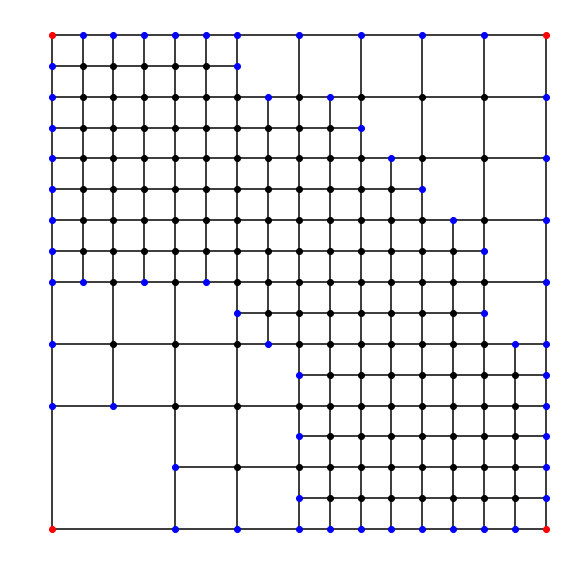

In [15]:
plt.close('all')
fig = plt.figure(figsize = (10,10))

for i in range(numvert):
    myvert = vertex_list[i]
    my_x, my_y = from_morton(myvert.morton)
    my_n = num_neighbors[i]
        
    r_i = R_neighbors[i]
    
    if r_i != None:
        r_x,r_y = from_morton(vertex_list[r_i].morton)
        plt.plot([my_y,r_y],[my_x,r_x],'k-')
    
    d_i = D_neighbors[i]
    
    if d_i != None:
        d_x, d_y = from_morton(vertex_list[d_i].morton)
        plt.plot([my_y,d_y],[my_x,d_x],'k-')
        
for i in range(numvert):
    myvert = vertex_list[i]
    my_x, my_y = from_morton(myvert.morton)
    my_n = num_neighbors[i]
    
    if my_n == 2:
        plt.plot(my_y,my_x,'ro')
    elif my_n == 3:
        plt.plot(my_y,my_x,'bo')
    else:
        plt.plot(my_y,my_x,'ko')

plt.axis('scaled')
plt.axis('off')
plt.show()